<a href="https://colab.research.google.com/github/j28905/TensorFlow/blob/main/tf_images_flores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar librerias

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)


2.8.0


Descargamos un dataset de imagenes de flores

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


tenemos 3670 imagenes, se calcula iterando el directioro donde estan las imagenes y seleccionando todos los ficheros que acaben en *.jpeg

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


las flores estan organizadas en directorios segun su tipo:

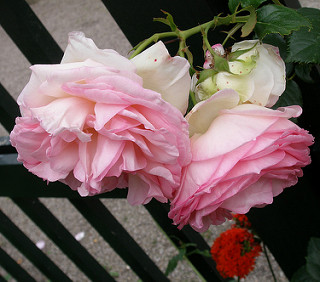

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

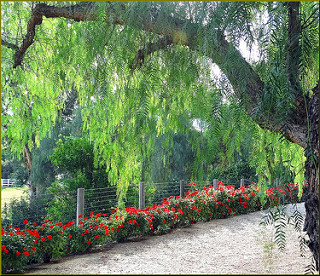

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

Cargar datos usando una utilidad de Keras

Crear conjunto de datos:

Definir parametros para el cargador

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Son buenas practicas el usar una division de validacion al desarrollar su modelo. el 80% para entrenamiento y el 20% para la validacion.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Se puede ver los nombrer de clase en el atributo class_names 

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


para visualizar los datos se usa matplotlib.pyplot

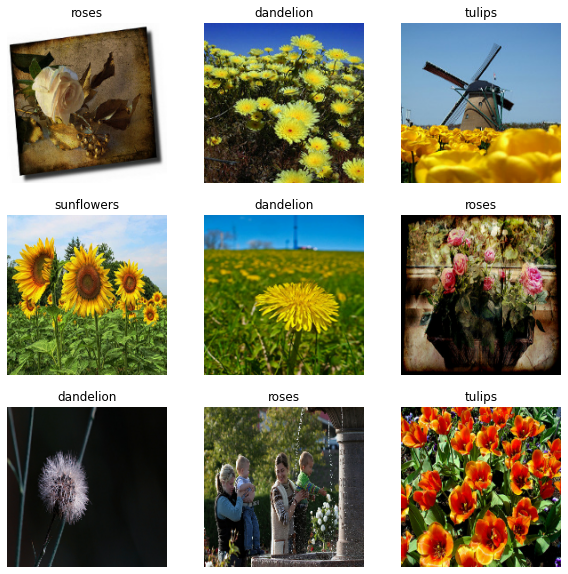

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Se puede entrenar un modelo sando estos conjuntos pasandoselos a model.fit. Tambien se puede iterar manualmente sobre el conjunto de datos y recuperar lotes de imagenes.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


image_batch es un tensor de la forma (32, 180, 180, 3) . Este es un lote de 32 imágenes de forma 180x180x3 (la última dimensión se refiere a los canales de color RGB). El label_batch es un tensor de la forma (32,) , estas son las etiquetas correspondientes a las 32 imágenes.

Estandarizar los datos

Los valores del canal RGB están en el rango [0, 255] . Esto no es ideal para una red neuronal; en general, debe buscar que sus valores de entrada sean pequeños.

Aquí, estandarizará los valores para que estén en el rango [0, 1] usando tf.keras.layers.Rescaling :

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


Esta capa se puede usar de dos modos distintos.

Se puede aplicar directamente al conjunto de datos de entrenamiento, train_ds, usando la funcion Dataset.map:


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


O puede incluir la capa dentro de la definición de su modelo para simplificar la implementación. Aquí utilizará el segundo enfoque.

Nota: si desea escalar los valores de píxeles a [-1,1] , puede escribir tf.keras.layers.Rescaling(1./127.5, offset=-1)

Nota: anteriormente cambiaste el tamaño de las imágenes usando el argumento image_size de tf.keras.utils.image_dataset_from_directory . Si también desea incluir la lógica de cambio de tamaño en su modelo, puede usar la capa tf.keras.layers.Resizing .

Configurar el conjunto de datos para el rendimiento
Asegurémonos de utilizar la captación previa almacenada en búfer para que pueda obtener datos del disco sin que la E/S se convierta en un bloqueo. Estos son dos métodos importantes que debe usar al cargar datos:

Dataset.cache mantiene las imágenes en la memoria después de que se cargan fuera del disco durante la primera época. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena su modelo. Si su conjunto de datos es demasiado grande para caber en la memoria, también puede usar este método para crear un caché en disco de alto rendimiento.

Dataset.prefetch superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Entrenamiento


Para completar, mostrará cómo entrenar un modelo simple utilizando los conjuntos de datos que acaba de preparar.

El modelo secuencial consta de tres bloques de convolución ( tf.keras.layers.Conv2D ) con una capa de agrupación máxima ( tf.keras.layers.MaxPooling2D ) en cada uno de ellos. Hay una capa totalmente conectada ( tf.keras.layers.Dense ) con 128 unidades encima que se activa mediante una función de activación de ReLU ( 'relu' ). Este modelo no se ha ajustado de ninguna manera: el objetivo es mostrarle la mecánica utilizando los conjuntos de datos que acaba de crear. Para obtener más información sobre la clasificación de imágenes, visite el tutorial de clasificación de imágenes .

In [18]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Elija el optimizador tf.keras.optimizers.Adam y la función de pérdida tf.keras.losses.SparseCategoricalCrossentropy . Para ver la precisión del entrenamiento y la validación para cada época de entrenamiento, pase el argumento de metrics a Model.compile .

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 82s 876ms/step - loss: 1.3345 - accuracy: 0.4210 - val_loss: 1.1575 - val_accuracy: 0.5450
Epoch 2/3
92/92 [==============================] - 93s 1s/step - loss: 1.0709 - accuracy: 0.5732 - val_loss: 0.9853 - val_accuracy: 0.6022
Epoch 3/3
92/92 [==============================] - 82s 893ms/step - loss: 0.9134 - accuracy: 0.6413 - val_loss: 0.9297 - val_accuracy: 0.6444


 la precisión de la validación es baja en comparación con la precisión del entrenamiento, lo que indica que el modelo se está sobreajustando

La utilidad de preprocesamiento de Keras anterior, tf.keras.utils.image_dataset_from_directory , es una forma conveniente de crear un tf.data.Dataset a partir de un directorio de imágenes.

Para un control de grano más fino, puede escribir su propia canalización de entrada usando tf.data . Esta sección muestra cómo hacerlo, comenzando con las rutas de archivo del archivo TGZ que descargó anteriormente.

In [22]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [23]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/tulips/11746548_26b3256922_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/5360769702_ec28c53b9e_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/18766965343_9f42d4bedc_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/921252114_91e334b950.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/151898652_b5f1c70b98_n.jpg'


Dividir el conjunto de datos en conjuntos de entrenamiento y validación:

In [24]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

Imprimir la longitud de cada conjunto de datos 

In [25]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Escribir una función breve que convierta una ruta de archivo en un par (img, label) :

In [26]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [27]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [28]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use Dataset.map para crear un conjunto de datos de pares de image, label :

In [29]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [30]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


Configurar el dataset para el rendimiento


Para entrenar el modelo queremos los datos:

  -Con alta aleatoriedad

  -Dosificados

  -Rapidez en la disponibilidad de los lotes

  Se pueden usar estas caracteristicas usando la API tf.data

In [31]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Visualizar los datos

Se pueden visualizar de una manera similar al metodo anterior.

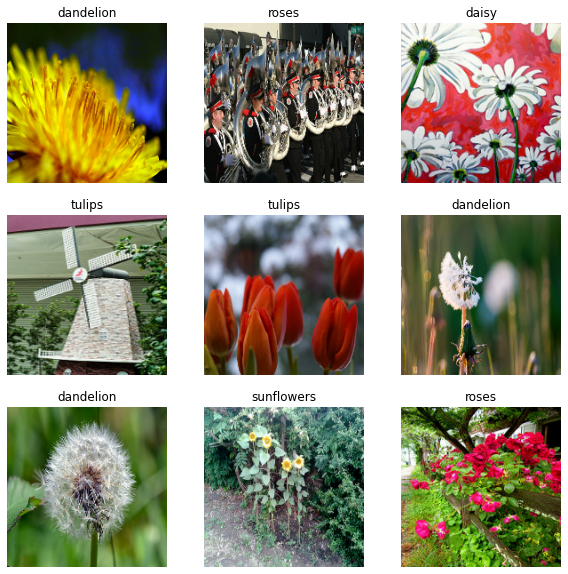

In [32]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Continuar entrenando el modelo


Ahora que tenemos un tf.data.Dataset similar al creado usando tf.keras.utils.image_dataset_from_diretory

In [33]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 86s 908ms/step - loss: 0.7745 - accuracy: 0.7020 - val_loss: 0.7027 - val_accuracy: 0.7262
Epoch 2/3
92/92 [==============================] - 82s 891ms/step - loss: 0.6052 - accuracy: 0.7793 - val_loss: 0.7050 - val_accuracy: 0.7262
Epoch 3/3
92/92 [==============================] - 78s 847ms/step - loss: 0.4284 - accuracy: 0.8512 - val_loss: 0.7820 - val_accuracy: 0.7112


Hasta ahora se han cargado datos fuera del disco

Ahora lo importamos desde TensorFlowDatasets

In [34]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


Calculamos el numero de clases del dataset

In [35]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


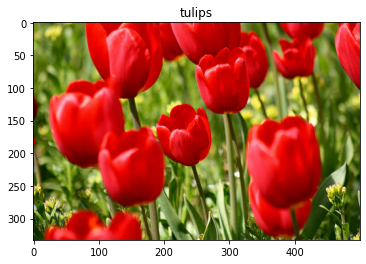

In [36]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Agrupamos,mezclamos y configuramos los datasets

In [37]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)